# Frozen-MLP causal tracing

This notebook executes causal traces with all the MLP modules for a token disabled (we also do Attn modules separately), by freezing them at the corrupted state.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
ALL_DEPS = False
try:
    import google.colab, torch, os
    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [3]:
import os, re
import torch, numpy
import importlib, copy
import transformers
from collections import defaultdict
from util import nethook
from matplotlib import pyplot as plt
from experiments.causal_trace import ModelAndTokenizer, make_inputs, predict_from_input, decode_tokens
from experiments.causal_trace import layername, find_token_range, trace_with_patch, plot_trace_heatmap
from util.globals import DATA_DIR
from dsets import KnownsDataset
import json


# model_name = r"gpt2-xl"
# model_name = r"EleutherAI/gpt-neox-20b

model_name = r"EleutherAI/gpt-j-6B"

mt = ModelAndTokenizer(model_name, low_cpu_mem_usage=IS_COLAB, torch_dtype=torch.float16)

layernum = 48
noiseParam = 0.1
if model_name == r"EleutherAI/gpt-neox-20b":
    noiseParam = 0.03
elif model_name == r"EleutherAI/gpt-j-6B":
    layernum = 28
    noiseParam = 0.025

In [4]:
print(mt.model)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
  

## Tracing a single location

The strategy here is to use three interventions, rather than two:

1. As before, corrupt a subset of the input.
2. As before, restore a subset of the internal hidden states to see
   which ones restore the output.
3. But now, while doing so, freeze a set of MLP modules when processing
   the specific subject token, so that they are stuck in the corrupted
   state.  This reveals effect of the hidden states on everything
   except for those particular MLP executions.
   
This three-way intervention is implemented in `trace_with_repatch`

In [5]:
def trace_with_repatch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    states_to_unpatch,  # A list of (token index, layername) triples to re-randomize
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    unpatch_spec = defaultdict(list)
    for t, l in states_to_unpatch:
        unpatch_spec[l].append(t)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == "transformer.wte":
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if first_pass or (layer not in patch_spec and layer not in unpatch_spec):
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec.get(layer, []):
            h[1:, t] = h[0, t]
        for t in unpatch_spec.get(layer, []):
            h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    for first_pass in [True, False] if states_to_unpatch else [False]:
        with torch.no_grad(), nethook.TraceDict(
            model,
            ["transformer.wte"] + list(patch_spec.keys()) + list(unpatch_spec.keys()),
            edit_output=patch_rep,
        ) as td:
            outputs_exp = model(**inp)
            if first_pass:
                first_pass_trace = td

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    return probs

## Tracing all locations

Now we just need to repeat it over all locations, and draw the heatmaps.

In [6]:
def calculate_hidden_flow_3(
    mt, prompt, subject, token_range=None, samples=10, noise=0.1, window=10,
    extra_token=0, disable_mlp=False, disable_attn=False
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    if token_range == 'last_subject':
        token_range = [e_range[1] - 1]
    e_range = (e_range[0], e_range[1] + extra_token)
    low_score = trace_with_patch(mt.model, inp, [], answer_t, e_range,
            noise=noise).item()
    differences = trace_important_states_3(
        mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise,
        disable_mlp=disable_mlp, disable_attn=disable_attn, token_range=token_range
    )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind="",
    )

def trace_important_states_3(model, num_layers, inp, e_range, answer_t, noise=0.1, disable_mlp=False, disable_attn=False, token_range=None):
    ntoks = inp["input_ids"].shape[1]
    table = []
    zero_mlps = []
    if token_range is None:
        token_range = range(ntoks)
    for tnum in token_range:
        zero_mlps = []
        if disable_mlp:
            zero_mlps = [(tnum, layername(model, L, 'mlp')) for L in range(0, num_layers)]
        if disable_attn:
            zero_mlps += [(tnum, layername(model, L, 'attn')) for L in range(0, num_layers)]
        row = []
        for layer in range(0, num_layers):
            r = trace_with_repatch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                zero_mlps, # states_to_unpatch
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

Here is a causal trace with MLP disabled - it looks quite different from normal.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


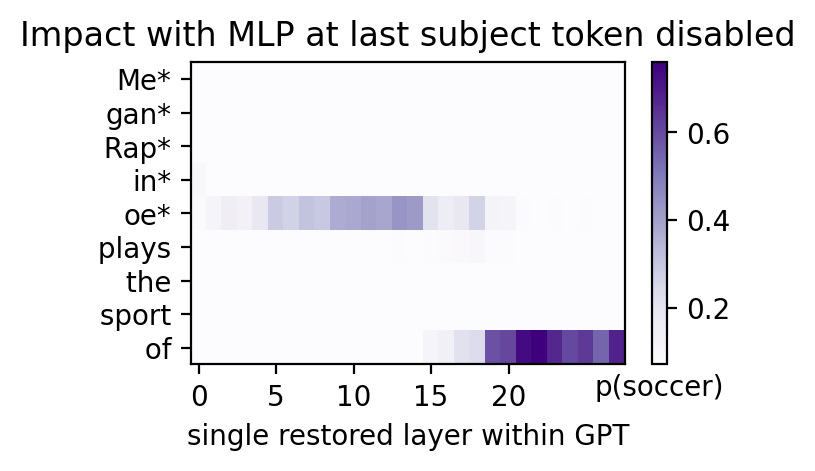

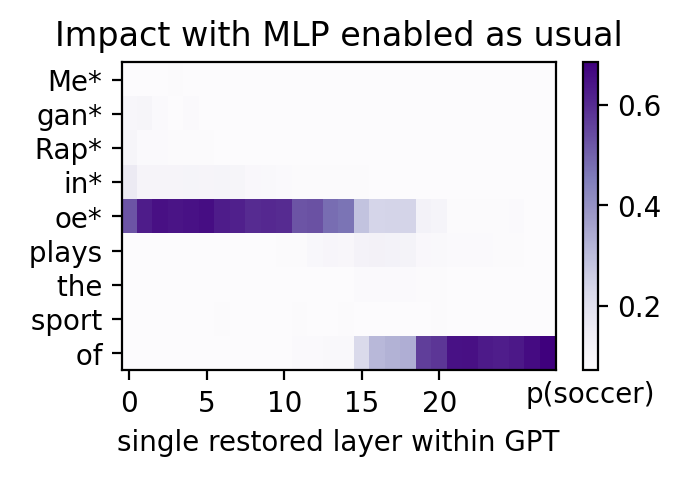

In [7]:
prefix = 'Megan Rapinoe plays the sport of'
entity = 'Megan Rapinoe'

no_attn_r = calculate_hidden_flow_3(mt, prefix, entity, disable_mlp=True, noise=noiseParam)
plot_trace_heatmap(no_attn_r, title='Impact with MLP at last subject token disabled')
ordinary_r = calculate_hidden_flow_3(mt, prefix, entity, noise=noiseParam)
plot_trace_heatmap(ordinary_r, title='Impact with MLP enabled as usual')

## Comparing the with-MLP/Attn and without-MLP/Attn traces

Plotting on a bar graph makes it easier to see the difference between the causal effects with and without MLP enabled.

In [8]:
def plot_last_subject(mt, prefix, entity, token_range='last_subject', savepdf=None, noise=0.1):
    ordinary, no_attn, no_mlp = calculate_last_subject(mt, prefix, entity, token_range=token_range, noise=noise)
    plot_comparison(ordinary, no_attn, no_mlp, prefix, savepdf=savepdf)

def calculate_last_subject(mt, prefix, entity, cache=None, token_range='last_subject', noise=0.1):
    def load_from_cache(filename):
        try:
            dat = numpy.load(f'{cache}/{filename}')
            return {k: v if not isinstance(v, numpy.ndarray)
                   else str(v) if v.dtype.type is numpy.str_
                   else torch.from_numpy(v)
                   for k, v in dat.items()}
        except FileNotFoundError as e:
            return None
    no_attn_r = load_from_cache('no_attn_r.npz')
    uncached_no_attn_r = no_attn_r is None
    no_mlp_r = load_from_cache('no_mlp_r.npz')
    uncached_no_mlp_r = no_mlp_r is None
    ordinary_r = load_from_cache('ordinary.npz')
    uncached_ordinary_r = ordinary_r is None
    if uncached_no_attn_r:
        no_attn_r = calculate_hidden_flow_3(mt, prefix, entity, disable_attn=True, token_range=token_range, noise=noise)
    if uncached_no_mlp_r:
        no_mlp_r = calculate_hidden_flow_3(mt, prefix, entity, disable_mlp=True, token_range=token_range, noise=noise)
    if uncached_ordinary_r:
        ordinary_r = calculate_hidden_flow_3(mt, prefix, entity, token_range=token_range, noise=noise)
    if cache is not None:
        os.makedirs(cache, exist_ok=True)
        for u, r, filename in [(uncached_no_attn_r, no_attn_r, 'no_attn_r.npz'),
                               (uncached_no_mlp_r, no_mlp_r, 'no_mlp_r.npz'),
                               (uncached_ordinary_r, ordinary_r, 'ordinary.npz')]:
            if u:
                numpy.savez(f'{cache}/{filename}',
                            **{k: v.cpu().numpy() if torch.is_tensor(v) else v for k, v in r.items()})
    if False:
        return (
            ordinary_r['scores'][0],
            no_attn_r['scores'][0],
            no_mlp_r['scores'][0])
    return (
        ordinary_r['scores'][0] - ordinary_r['low_score'],
        no_attn_r['scores'][0] - ordinary_r['low_score'],
        no_mlp_r['scores'][0] - ordinary_r['low_score'])
        
    # return ordinary_r['scores'][0], no_attn_r['scores'][0]

def plot_comparison(ordinary, no_attn, no_mlp, title, savepdf=None):
    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        import matplotlib.ticker as mtick
        fig, ax = plt.subplots(1, figsize=(6, 1.5), dpi=300)
        ax.bar([i - 0.3 for i in range(layernum)], ordinary, width=0.3, color='#7261ab', label='Impact of single state on P')
        ax.bar([i  for i in range(layernum)], no_attn, width=0.3, color='#f3201b', label='Impact with Attn severed')
        ax.bar([i + 0.3 for i in range(layernum)], no_mlp, width=0.3, color='#20b020', label='Impact with MLP severed')
        ax.set_title(title) #'Impact of individual hidden state at last subject token with MLP disabled')
        ax.set_ylabel('Indirect Effect')
        #ax.set_xlabel('Layer at which the single hidden state is restored')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(None, max(0.025, ordinary.max() * 1.05))
        ax.legend()
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

if False: # Some representative cases.
    plot_last_subject(mt, "Megan Rapinoe plays the sport of", "Megan Rapinoe", noise=noiseParam)
    plot_last_subject(mt, "The Big Bang Theory premires on", "The Big Bang Theory", noise=noiseParam)
    plot_last_subject(mt, "Germaine Greer's domain of work is", "Germaine Greer", noise=noiseParam)
    plot_last_subject(mt, "Brian de Palma works in the area of", "Brian de Palma", noise=noiseParam)
    plot_last_subject(mt, "The headquarter of Zillow is in downtown", "Zillow", noise=noiseParam)
    plot_last_subject(mt, "Mitsubishi Electric started in the 1900s as a small company in", "Mitsubishi", noise=noiseParam)
    plot_last_subject(mt, "Mitsubishi Electric started in the 1900s as a small company in", "Mitsubishi Electric", noise=noiseParam)
    plot_last_subject(mt, "Madame de Montesson died in the city of", "Madame", noise=noiseParam)
    plot_last_subject(mt, "Madame de Montesson died in the city of", "Madame de Montesson", noise=noiseParam)
    plot_last_subject(mt, "Edmund Neupert, performing on the", "Edmund Neupert", noise=noiseParam)

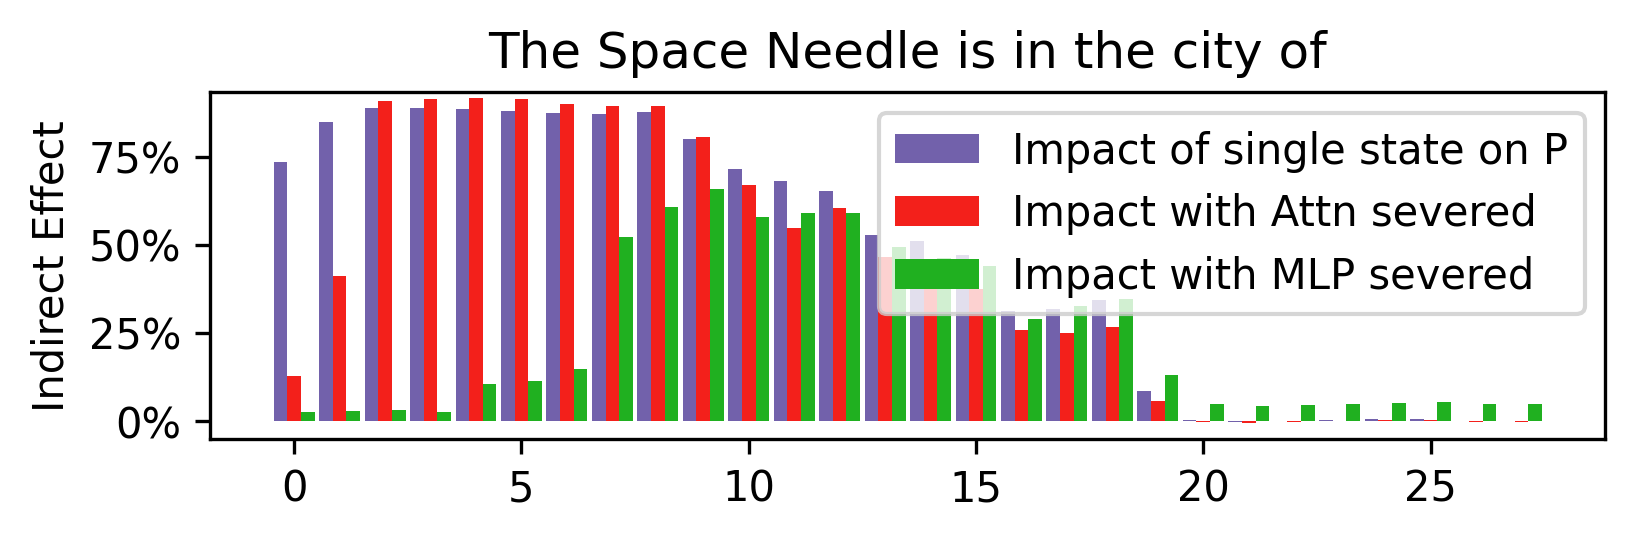

In [9]:
plot_last_subject(mt, "The Space Needle is in the city of", "The Space Needle", noise=noiseParam)

## Average Indirect Effects

Now we average over hundreds of factual statements.

In [10]:
import tqdm
knowns = KnownsDataset(DATA_DIR)
all_ordinary = []
all_no_attn = []
all_no_mlp = []
val_act_pairs = json.load(open("../dsets/Values_actions_pairs_formatted.json"))

for i, knowledge in enumerate(val_act_pairs):
    print(i)
    # plot_all_flow(mt, knowledge['prompt'], knowledge['subject'])
    ordinary, no_attn, no_mlp = calculate_last_subject(mt, knowledge['prompt'], knowledge['subject'], cache=f'results/ct_disable_attn/case_{i}', noise=noiseParam)
    all_ordinary.append(ordinary)
    all_no_attn.append(no_attn)
    all_no_mlp.append(no_mlp)
title = 'Causal effect of states at the early site with Attn or MLP modules severed'

avg_ordinary = torch.stack(all_ordinary).mean(dim=0)
avg_no_attn = torch.stack(all_no_attn).mean(dim=0)
avg_no_mlp = torch.stack(all_no_mlp).mean(dim=0)


Loaded dataset with 1209 elements
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


[tensor(-0.0159), tensor(-0.0136), tensor(-0.0127)]
tensor(0.0040) tensor(0.0048) tensor(0.0042)


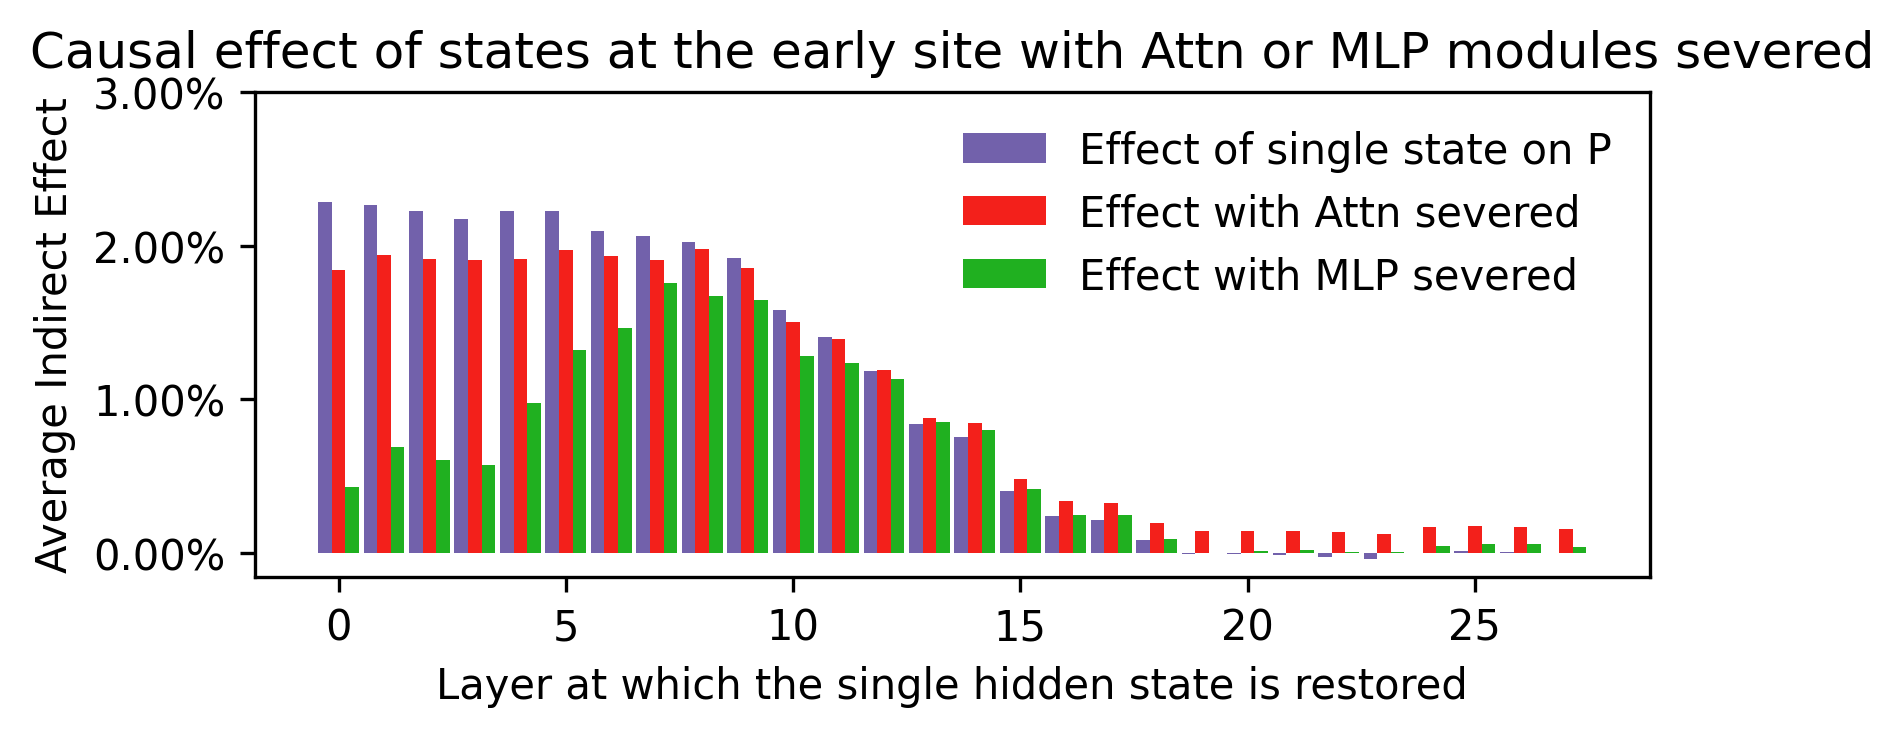

In [12]:
import matplotlib.ticker as mtick
with plt.rc_context(rc={"font.family": "Times New Roman"}):
    fig, ax = plt.subplots(1, figsize=(6, 2.1), dpi=300)
    ax.bar([i - 0.3 for i in range(layernum)], avg_ordinary, width=0.3, color='#7261ab', label='Effect of single state on P')
    ax.bar([i for i in range(layernum)], avg_no_attn, width=0.3, color='#f3201b', label='Effect with Attn severed')
    ax.bar([i + 0.3 for i in range(layernum)], avg_no_mlp, width=0.3, color='#20b020', label='Effect with MLP severed')
    ax.set_title(title) #'Impact of individual hidden state at last subject token with MLP disabled')
    ax.set_ylabel('Average Indirect Effect')
    ax.set_xlabel('Layer at which the single hidden state is restored')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(None, max(0.025, 0.03))

    ax.legend(frameon=False)
fig.savefig('causal-trace-no-attn-mlp.pdf', bbox_inches='tight')
print([d[20] - d[10] for d in [avg_ordinary, avg_no_attn, avg_no_mlp]])
print(avg_ordinary[15], avg_no_attn[15], avg_no_mlp[15])